✓ Config Loaded (Random Forest Edition)

=== 1. DATA LOADING ===
🎉 Merged Data: (27323, 28)

=== 2. PREPROCESSING ===
Base Features: ['rain', 'soil', 'temp', 'humi', 'geo', 'rain_cum_24h', 'rain_cum_3d', 'soil_rate', 'geo_abs']

=== 3. FLATTENING ===
Input Shape: (12442, 270)

=== 4. SPLIT & BALANCE ===
Balanced Train: Counter({np.int64(0): 5000, np.int64(2): 5000, np.int64(1): 5000})

=== 5. RANDOM FOREST TRAINING ===


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    1.8s finished



✓ Random Forest Model Saved.

=== 6. EVALUATION ===

>>> VALIDATION SET RESULTS <<<
Accuracy: 0.9684

Confusion Matrix:
[[1724   22    7]
 [  17   45    4]
 [   2    7   39]]

Classification Report:
              precision    recall  f1-score   support

      Normal       0.99      0.98      0.99      1753
     Warning       0.61      0.68      0.64        66
    Critical       0.78      0.81      0.80        48

    accuracy                           0.97      1867
   macro avg       0.79      0.83      0.81      1867
weighted avg       0.97      0.97      0.97      1867


>>> TEST SET RESULTS <<<


[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 200 out of 200 | elapsed:    0.0s finished


Accuracy: 0.9770

Confusion Matrix:
[[1725   19    9]
 [   6   56    4]
 [   0    5   43]]

Classification Report:
              precision    recall  f1-score   support

      Normal       1.00      0.98      0.99      1753
     Warning       0.70      0.85      0.77        66
    Critical       0.77      0.90      0.83        48

    accuracy                           0.98      1867
   macro avg       0.82      0.91      0.86      1867
weighted avg       0.98      0.98      0.98      1867


=== TOP 15 IMPORTANT FEATURES ===


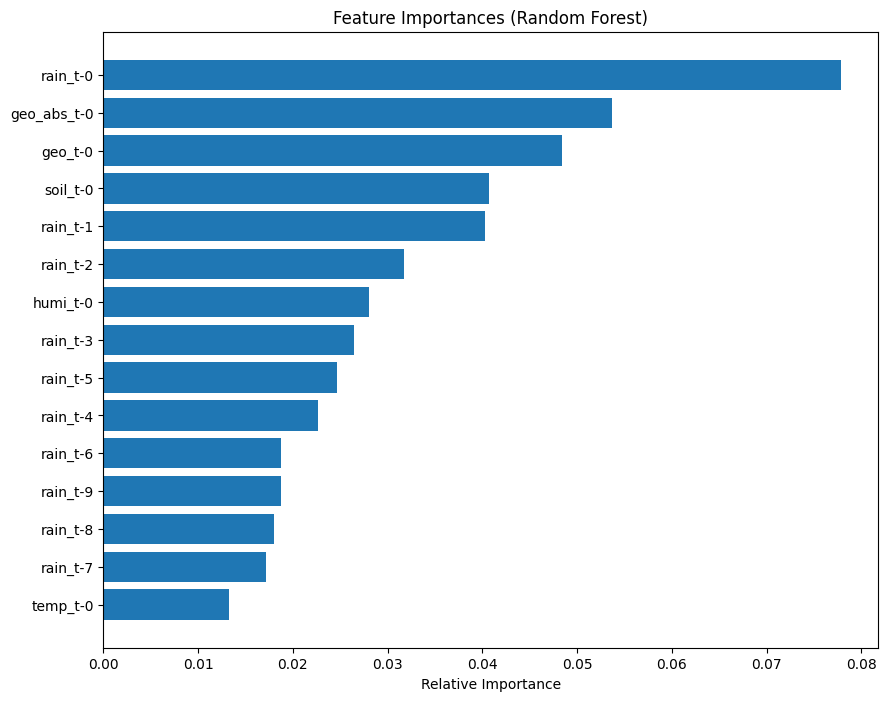

In [1]:
# %%
"""
=========================================================================================
PROJECT: LANDSLIDE DETECTION - RANDOM FOREST EDITION
โครงการ: ระบบตรวจจับดินถล่มด้วย Random Forest (เสถียร ง่าย และแม่นยำ)
=========================================================================================

[WORKFLOW]
1. AUTO-MERGE: รวมไฟล์ CSV อัตโนมัติ
2. PREPROCESS: Resample -> Physics Features
3. FLATTENING: แปลงข้อมูลย้อนหลัง 30 นาที ให้เป็นแถวเดียว (2D Array)
4. RANDOM FOREST: ใช้พลังของต้นไม้หลายร้อยต้นช่วยกันโหวต (Ensemble)
"""

# %%
# ====================================================================
# 1. CONFIGURATION
# ====================================================================
import os
import glob
import re
import random
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.ensemble import RandomForestClassifier

import warnings
warnings.filterwarnings('ignore')

class Config:
    # --- PATHS ---
    DATA_DIR = "./data/" 
    
    # --- OUTPUTS ---
    OUTPUT_MODEL = "landslide_rf_model.joblib" # Sklearn ใช้ Joblib
    OUTPUT_SCALER = "landslide_rf_scaler.save"
    
    # --- SETTINGS ---
    SEQUENCE_LENGTH = 30   
    TEST_SIZE = 0.15
    VAL_SIZE  = 0.15 
    OVERSAMPLE_TARGET = 5000
    
    # Random Forest Params
    RF_PARAMS = {
        'n_estimators': 200,      # จำนวนต้นไม้ (ยิ่งเยอะยิ่งเสถียร แต่ช้า)
        'max_depth': 15,          # ความลึกสูงสุดของต้นไม้ (กัน Overfit)
        'min_samples_split': 5,   # แตกกิ่งเมื่อมีข้อมูลอย่างน้อย 5 ตัว
        'class_weight': 'balanced', # ช่วยเรื่อง Imbalance ในตัว
        'n_jobs': -1,             # ใช้ทุก Core CPU
        'random_state': 42,
        'verbose': 1
    }
    
    # Columns
    RAW_COLS = ['rain', 'soil', 'temp', 'humi', 'geo']
    LABEL_COL = 'label'
    LABEL_MAP = {'normal':0, 'warning':1, 'critical':2}

cfg = Config()
np.random.seed(42); random.seed(42)
print("✓ Config Loaded (Random Forest Edition)")

# %%
# ====================================================================
# 2. DYNAMIC DATA LOADING
# ====================================================================
print("\n=== 1. DATA LOADING ===")

def standardize_columns(df):
    df = df.copy()
    df.columns = [str(c).lower().strip().replace('.1', '') for c in df.columns]
    rename_map = {
        'temperature':'temp', 'hum':'humi', 'humidity':'humi',
        'devid': 'devID', 'deviceid': 'devID', 'device': 'devID', 'node': 'devID',
        'time': 'timestamp', 'date': 'timestamp'
    }
    new_cols = {c: rename_map[c] for c in df.columns if c in rename_map}
    if new_cols: df = df.rename(columns=new_cols)
    
    if 'devID' in df.columns:
        df['devID'] = df['devID'].astype(str).apply(lambda x: int(re.search(r'(\d+)', x).group(1)) if re.search(r'(\d+)', x) else 0)
    if 'timestamp' in df.columns:
        df['timestamp'] = pd.to_datetime(df['timestamp'], errors='coerce')
    for c in cfg.RAW_COLS:
        if c not in df.columns: df[c] = 0.0
    return df

all_files = glob.glob(os.path.join(cfg.DATA_DIR, "*.csv"))
if not all_files: raise FileNotFoundError("No CSV files found.")

df_list = [standardize_columns(pd.read_csv(f)) for f in all_files]
df_all = pd.concat(df_list, ignore_index=True)
print(f"🎉 Merged Data: {df_all.shape}")

# %%
# ====================================================================
# 3. PREPROCESSING
# ====================================================================
print("\n=== 2. PREPROCESSING ===")

def preprocess_pipeline(df):
    parts = []
    agg_rules = {'rain': 'max', 'soil': 'max', 'geo': 'std', 'temp': 'mean', 'humi': 'mean'}
    for c in cfg.RAW_COLS: 
        if c not in agg_rules: agg_rules[c] = 'mean'

    for dev, g in df.groupby('devID'):
        if g.empty: continue
        g = g.sort_values('timestamp').set_index('timestamp')
        g = g[~g.index.duplicated(keep='first')]
        
        if len(g) > 0: g = g.resample('1T').asfreq()
        g[list(agg_rules.keys())] = g[list(agg_rules.keys())].interpolate(limit_direction='both').fillna(0)
        
        # Physics Features
        g['rain_cum_24h'] = g['rain'].rolling(1440, min_periods=1).sum()
        g['rain_cum_3d']  = g['rain'].rolling(4320, min_periods=1).sum()
        g['soil_rate']    = g['soil'].diff().fillna(0)
        g['geo_abs']      = g['geo'].abs()
        
        if cfg.LABEL_COL in g.columns:
            g[cfg.LABEL_COL] = g[cfg.LABEL_COL].fillna('normal').astype(str).str.lower().str.strip()
            g[cfg.LABEL_COL] = g[cfg.LABEL_COL].map(cfg.LABEL_MAP).fillna(0).astype(int)
        else:
            g[cfg.LABEL_COL] = 0
            
        g['devID'] = dev
        parts.append(g.reset_index())
        
    return pd.concat(parts, ignore_index=True)

df_proc = preprocess_pipeline(df_all)
FEATURES = cfg.RAW_COLS + ['rain_cum_24h', 'rain_cum_3d', 'soil_rate', 'geo_abs']
print(f"Base Features: {FEATURES}")

# %%
# ====================================================================
# 4. FLATTENING (Sequence -> Vector)
# ====================================================================
print("\n=== 3. FLATTENING ===")

def create_flattened_dataset(df):
    Xs, ys = [], []
    flat_feature_names = []
    # Create names: rain_t-0, rain_t-1 ...
    for i in range(cfg.SEQUENCE_LENGTH):
        for f in FEATURES:
            flat_feature_names.append(f"{f}_t-{cfg.SEQUENCE_LENGTH-1-i}")
            
    for dev, g in df.groupby('devID'):
        data = g[FEATURES].values
        labels = g[cfg.LABEL_COL].values
        if len(g) < cfg.SEQUENCE_LENGTH: continue
        
        for i in range(len(g) - cfg.SEQUENCE_LENGTH + 1):
            window = data[i : i+cfg.SEQUENCE_LENGTH]
            Xs.append(window.flatten()) # 30x9 -> 270
            ys.append(labels[i+cfg.SEQUENCE_LENGTH-1])
            
    return np.array(Xs), np.array(ys), flat_feature_names

X_data, y_data, feature_names = create_flattened_dataset(df_proc)
print(f"Input Shape: {X_data.shape}")

# %%
# ====================================================================
# 5. SPLIT & BALANCE
# ====================================================================
print("\n=== 4. SPLIT & BALANCE ===")

# Split
X_temp, X_test, y_temp, y_test = train_test_split(
    X_data, y_data, test_size=cfg.TEST_SIZE, stratify=y_data, random_state=42
)
val_ratio = cfg.VAL_SIZE / (1.0 - cfg.TEST_SIZE)
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=val_ratio, stratify=y_temp, random_state=42
)

# Oversample
def oversample(X, y, target):
    X_res, y_res = [], []
    for cls in np.unique(y):
        idx = np.where(y == cls)[0]
        if len(idx) == 0: continue
        chosen = np.random.choice(idx, target, replace=True)
        X_res.append(X[chosen]); y_res.append(y[chosen])
    X_out = np.concatenate(X_res); y_out = np.concatenate(y_res)
    perm = np.random.permutation(len(X_out))
    return X_out[perm], y_out[perm]

X_train_bal, y_train_bal = oversample(X_train, y_train, cfg.OVERSAMPLE_TARGET)
print(f"Balanced Train: {Counter(y_train_bal)}")

# Scale
scaler = StandardScaler()
scaler.fit(X_train_bal)
X_train_s = scaler.transform(X_train_bal)
X_val_s   = scaler.transform(X_val)
X_test_s  = scaler.transform(X_test)

joblib.dump(scaler, cfg.OUTPUT_SCALER)

# %%
# ====================================================================
# 6. RANDOM FOREST TRAINING
# ====================================================================
print("\n=== 5. RANDOM FOREST TRAINING ===")

# Initialize & Train
model = RandomForestClassifier(**cfg.RF_PARAMS)
model.fit(X_train_s, y_train_bal)

# Save
joblib.dump(model, cfg.OUTPUT_MODEL)
print("\n✓ Random Forest Model Saved.")

# %%
# ====================================================================
# 7. EVALUATION & FEATURE IMPORTANCE
# ====================================================================
print("\n=== 6. EVALUATION ===")

def evaluate_rf(name, X, y_true):
    print(f"\n>>> {name} RESULTS <<<")
    y_pred = model.predict(X)
    
    print(f"Accuracy: {accuracy_score(y_true, y_pred):.4f}")
    print("\nConfusion Matrix:")
    print(confusion_matrix(y_true, y_pred))
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, target_names=['Normal', 'Warning', 'Critical']))

evaluate_rf("VALIDATION SET", X_val_s, y_val)
evaluate_rf("TEST SET", X_test_s, y_test)

# --- Feature Importance ---
print("\n=== TOP 15 IMPORTANT FEATURES ===")
importances = model.feature_importances_
indices = np.argsort(importances)[::-1][:15] # Top 15

plt.figure(figsize=(10, 8))
plt.title("Feature Importances (Random Forest)")
plt.barh(range(15), importances[indices], align="center")
plt.yticks(range(15), [feature_names[i] for i in indices])
plt.gca().invert_yaxis()
plt.xlabel("Relative Importance")
plt.show()